## Final Model Comparison: 2026 Box Office Prediction

In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys

_NOTEBOOK_DIR = Path().resolve()
_candidate_paths = [
    _NOTEBOOK_DIR,
    _NOTEBOOK_DIR / 'code',
    _NOTEBOOK_DIR.parent,
    _NOTEBOOK_DIR.parent / 'code',
]

for _candidate in _candidate_paths:
    if (_candidate / 'model_utils.py').exists():
        sys.path.insert(0, str(_candidate))
        break

from model_utils import (
    DEFAULT_EXCLUDE_COLS,
    prepare_features,
    evaluate_model,
    get_top10_predictions,
    create_sample_weights,
)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("🎬 Box Office Prediction: Final Model Comparison")
print("Using best trained models from experimentation (notebook 4)")

🎬 Box Office Prediction: Final Model Comparison
Using best trained models from experimentation (notebook 4)


In [2]:
# Load and prepare data with alternative time features
print("📊 Loading and Preparing Data")
print("=" * 50)

# Load processed dataset
df = pd.read_csv('../data/dataset_domestic_processed.csv')

print(f"Dataset loaded: {df.shape[0]} movies, {df.shape[1]} features")
print(f"Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}")

📊 Loading and Preparing Data
Dataset loaded: 1416 movies, 94 features
Date range: 2015-2025
Revenue range: $521,202 - $936,662,225


In [3]:
# Prepare feature list via shared helper (keep both major & indie titles)
print("🎯 Strategic Focus: Full Dataset with Major-Studio Indicator")
print("=" * 60)

original_row_count = len(df)

df, feature_cols, target = prepare_features(
    df,
    exclude_cols=DEFAULT_EXCLUDE_COLS,
    filter_major_only=False,
    drop_major_flag_from_features=False,
    verbose=True,
)

major_share = df['is_major_studio'].mean() if 'is_major_studio' in df.columns else float('nan')
print(f"Total rows retained: {len(df):,} (of {original_row_count:,})")
if not np.isnan(major_share):
    print(f"   • Major studios: {int(df['is_major_studio'].sum()):,} ({major_share*100:.1f}%)")
print(f"Target variable: {target}")


🎯 Strategic Focus: Full Dataset with Major-Studio Indicator

🔧 Feature preparation summary:
   • Candidate features: 64
   • Columns with missing values:
     – days_to_holiday: 736 nulls
Total rows retained: 1,416 (of 1,416)
   • Major studios: 821 (58.0%)
Target variable: revenue_domestic


In [4]:
# Prepare training and validation data
print("📚 Preparing Training and Validation Data")
print("=" * 50)

# Split data by years (temporal validation)
train_data = df[df['release_year'].between(2015, 2023)].copy()
val_data = df[df['release_year'] == 2024].copy()
test_data = df[df['release_year'] == 2025].copy()

print(f"Data splits:")
print(f"   • Training (2015-2023): {len(train_data)} movies")
print(f"   • Validation (2024): {len(val_data)} movies")
print(f"   • Test (2025): {len(test_data)} movies")

# Create sample weights (best strategy from experimentation: weighted pandemic)
sample_weights = create_sample_weights(train_data)
pandemic_count = int(train_data['is_pandemic_year'].sum()) if 'is_pandemic_year' in train_data.columns else 0

print("Sample weighting:")
print(f"   • Normal years: 1.0 weight")
print(f"   • Pandemic years (2020-2021): 0.3 weight ({pandemic_count} movies)")

# Prepare feature matrices
X_train = train_data[feature_cols]
y_train = train_data[target]
y_train_log = np.log1p(y_train)  # Log transform for better model performance

X_val = val_data[feature_cols]
y_val = val_data[target]
y_val_log = np.log1p(y_val)

print("Feature matrices prepared:")
print(f"   • Training: {X_train.shape}")
print(f"   • Validation: {X_val.shape}")
print(f"   • Log-transformed target for better model performance")


📚 Preparing Training and Validation Data
Data splits:
   • Training (2015-2023): 1145 movies
   • Validation (2024): 159 movies
   • Test (2025): 112 movies
Sample weighting:
   • Normal years: 1.0 weight
   • Pandemic years (2020-2021): 0.3 weight (149 movies)
Feature matrices prepared:
   • Training: (1145, 64)
   • Validation: (159, 64)
   • Log-transformed target for better model performance


## Model 1: Ridge Regression

Linear model with L2 regularization. Good baseline with interpretable coefficients.

In [5]:
# Load saved Ridge Regression model
print("🔵 Loading Ridge Regression Model")
print("=" * 40)

ridge_path = '../models/best_ridge_model.pkl'
if os.path.exists(ridge_path):
    with open(ridge_path, 'rb') as f:
        ridge_data = pickle.load(f)
    
    ridge_model = ridge_data['model']
    ridge_strategy = ridge_data['strategy']
    ridge_rmse = ridge_data['rmse']
    ridge_r2 = ridge_data['r2']
    
    print(f"✅ Ridge model loaded successfully")
    print(f"   Strategy: {ridge_strategy}")
    print(f"   Training RMSE: ${ridge_rmse:,.0f}")
    print(f"   Training R²: {ridge_r2:.3f}")
    
    # Evaluate on validation data
    ridge_results = evaluate_model(ridge_model, X_val, y_val_log, y_val, "Ridge Regression")
else:
    print("❌ Ridge model file not found. Run notebook 4 first to train and save models.")
    ridge_results = None

🔵 Loading Ridge Regression Model
✅ Ridge model loaded successfully
   Strategy: All Eras (2015-2023)
   Training RMSE: $81,662,172
   Training R²: 0.393

Ridge Regression Performance:
  RMSE: $81,662,172
  MAE:  $34,075,467
  MAPE: 149.0%
  R²:   0.393


## Model 2: Decision Tree

Non-linear model that can capture feature interactions and thresholds.

In [6]:
# Load saved Decision Tree model
print("🌳 Loading Decision Tree Model")
print("=" * 40)

dt_path = '../models/best_decision_tree_model.pkl'
if os.path.exists(dt_path):
    with open(dt_path, 'rb') as f:
        dt_data = pickle.load(f)
    
    dt_model = dt_data['model']
    dt_strategy = dt_data['strategy']
    dt_rmse = dt_data['rmse']
    dt_r2 = dt_data['r2']
    
    print(f"✅ Decision Tree model loaded successfully")
    print(f"   Strategy: {dt_strategy}")
    print(f"   Training RMSE: ${dt_rmse:,.0f}")
    print(f"   Training R²: {dt_r2:.3f}")
    
    # Evaluate on validation data
    dt_results = evaluate_model(dt_model, X_val, y_val_log, y_val, "Decision Tree")
else:
    print("❌ Decision Tree model file not found. Run notebook 4 first to train and save models.")
    dt_results = None

🌳 Loading Decision Tree Model
✅ Decision Tree model loaded successfully
   Strategy: All Eras (2015-2023)
   Training RMSE: $80,903,869
   Training R²: 0.404

Decision Tree Performance:
  RMSE: $80,903,869
  MAE:  $34,691,065
  MAPE: 182.4%
  R²:   0.404


## Model 3: Random Forest

Ensemble of decision trees for improved generalization and reduced overfitting.

In [7]:
# Load saved Random Forest model
print("🌲 Loading Random Forest Model")
print("=" * 40)

rf_path = '../models/best_random_forest_model.pkl'
if os.path.exists(rf_path):
    with open(rf_path, 'rb') as f:
        rf_data = pickle.load(f)
    
    rf_model = rf_data['model']
    rf_strategy = rf_data['strategy']
    rf_rmse = rf_data['rmse']
    rf_r2 = rf_data['r2']
    
    print(f"✅ Random Forest model loaded successfully")
    print(f"   Strategy: {rf_strategy}")
    print(f"   Training RMSE: ${rf_rmse:,.0f}")
    print(f"   Training R²: {rf_r2:.3f}")
    
    # Evaluate on validation data
    rf_results = evaluate_model(rf_model, X_val, y_val_log, y_val, "Random Forest")
else:
    print("❌ Random Forest model file not found. Run notebook 4 first to train and save models.")
    rf_results = None

🌲 Loading Random Forest Model
✅ Random Forest model loaded successfully
   Strategy: No Pandemic Era
   Training RMSE: $83,841,416
   Training R²: 0.360

Random Forest Performance:
  RMSE: $83,841,416
  MAE:  $35,292,102
  MAPE: 174.1%
  R²:   0.360


## Model Comparison & Selection

In [8]:
# Compare all models
print("🏆 Final Model Comparison")
print("=" * 50)

# Check which models were loaded successfully
available_results = [result for result in [ridge_results, dt_results, rf_results] if result is not None]

if len(available_results) == 0:
    print("❌ No models found! Please run notebook 4 first to train and save models.")
else:
    # Create comparison dataframe
    comparison_df = pd.DataFrame([
        {
            'Model': result['model_name'],
            'RMSE': f"${result['rmse']:,.0f}",
            'MAE': f"${result['mae']:,.0f}",
            'MAPE': f"{result['mape']:.1f}%",
            'R²': f"{result['r2']:.3f}",
            'RMSE_raw': result['rmse']  # For sorting
        }
        for result in available_results
    ])

    # Sort by RMSE (best first)
    comparison_df = comparison_df.sort_values('RMSE_raw')
    comparison_df = comparison_df.drop('RMSE_raw', axis=1)

    print("Performance Summary (Best to Worst):")
    print(comparison_df.to_string(index=False))

    # Find best model
    best_model_idx = min(range(len(available_results)), key=lambda i: available_results[i]['rmse'])
    best_model_result = available_results[best_model_idx]
    best_model = best_model_result['model_object']

    print(f"\n🥇 WINNER: {best_model_result['model_name']}")
    print(f"   RMSE: ${best_model_result['rmse']:,.0f}")
    print(f"   R²: {best_model_result['r2']:.3f}")
    print(f"   MAPE: {best_model_result['mape']:.1f}%")
    
    print(f"\n✅ Models loaded from saved pickle files:")
    if ridge_results: print(f"   • Ridge Regression: {ridge_strategy}")
    if dt_results: print(f"   • Decision Tree: {dt_strategy}")
    if rf_results: print(f"   • Random Forest: {rf_strategy}")

🏆 Final Model Comparison
Performance Summary (Best to Worst):
           Model        RMSE         MAE   MAPE    R²
   Decision Tree $80,903,869 $34,691,065 182.4% 0.404
Ridge Regression $81,662,172 $34,075,467 149.0% 0.393
   Random Forest $83,841,416 $35,292,102 174.1% 0.360

🥇 WINNER: Decision Tree
   RMSE: $80,903,869
   R²: 0.404
   MAPE: 182.4%

✅ Models loaded from saved pickle files:
   • Ridge Regression: All Eras (2015-2023)
   • Decision Tree: All Eras (2015-2023)
   • Random Forest: No Pandemic Era


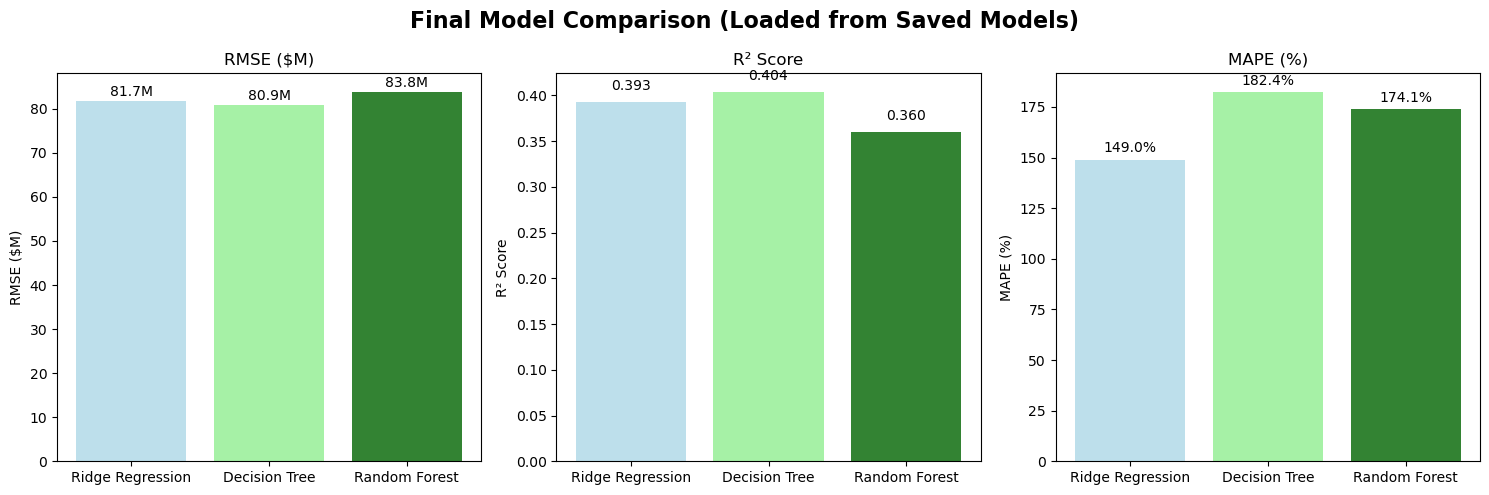

📊 Model comparison visualization complete


In [9]:
# Visualize model comparison
if len(available_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Final Model Comparison (Loaded from Saved Models)', fontsize=16, fontweight='bold')

    models = [result['model_name'] for result in available_results]
    colors = ['lightblue', 'lightgreen', 'darkgreen'][:len(available_results)]

    # RMSE comparison
    rmse_values = [result['rmse']/1e6 for result in available_results]
    bars1 = axes[0].bar(models, rmse_values, color=colors, alpha=0.8)
    axes[0].set_title('RMSE ($M)')
    axes[0].set_ylabel('RMSE ($M)')
    for bar, val in zip(bars1, rmse_values):
        axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                    f'{val:.1f}M', ha='center', va='bottom')

    # R² comparison
    r2_values = [result['r2'] for result in available_results]
    bars2 = axes[1].bar(models, r2_values, color=colors, alpha=0.8)
    axes[1].set_title('R² Score')
    axes[1].set_ylabel('R² Score')
    for bar, val in zip(bars2, r2_values):
        axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center', va='bottom')

    # MAPE comparison
    mape_values = [result['mape'] for result in available_results]
    bars3 = axes[2].bar(models, mape_values, color=colors, alpha=0.8)
    axes[2].set_title('MAPE (%)')
    axes[2].set_ylabel('MAPE (%)')
    for bar, val in zip(bars3, mape_values):
        axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                    f'{val:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("📊 Model comparison visualization complete")
else:
    print("❌ No models available for visualization")

## 2024 Validation: Top 10 Predictions vs Actual

In [10]:
# Test best model on 2024 validation data
if len(available_results) > 0:
    print("🎯 2024 Validation: Top 10 Predictions vs Actual")
    print("=" * 60)

    # Get top 10 predictions for 2024
    top10_2024 = get_top10_predictions(best_model, df, 2024, feature_cols)

    if top10_2024 is not None:
        # Format for display
        display_df = top10_2024.copy()
        display_df['predicted_revenue'] = display_df['predicted_revenue'].apply(lambda x: f"${x:,.0f}")
        if 'actual_revenue' in display_df.columns:
            display_df['actual_revenue'] = display_df['actual_revenue'].apply(lambda x: f"${x:,.0f}")
            display_df['prediction_error_pct'] = display_df['prediction_error_pct'].apply(lambda x: f"{x:+.1f}%")
        
        print(f"Top 10 Predicted vs Actual for 2024 ({best_model_result['model_name']}):")
        print(display_df.to_string(index=True))
        
        # Calculate ranking accuracy
        if 'actual_revenue' in top10_2024.columns:
            actual_top10 = df[df['release_year'] == 2024].nlargest(10, 'revenue_domestic')['title'].tolist()
            predicted_top10 = top10_2024['title'].tolist()
            overlap = len(set(actual_top10) & set(predicted_top10))
            
            print(f"\n📈 2024 Validation Accuracy:")
            print(f"   Movies correctly predicted in top 10: {overlap}/10 ({overlap*10}%)")
            
            if 'prediction_error_pct' in top10_2024.columns:
                avg_error = top10_2024['prediction_error_pct'].abs().mean()
                print(f"   Average prediction error: {avg_error:.1f}%")
            
            # Show missed and false positives
            missed = set(actual_top10) - set(predicted_top10)
            false_positives = set(predicted_top10) - set(actual_top10)
            
            if missed:
                print(f"\n   ❌ Missed (in actual top 10): {list(missed)}")
            if false_positives:
                print(f"   ⚠️  False positives: {list(false_positives)}")
    else:
        print("No 2024 validation data available")
else:
    print("❌ No models available for validation testing")

🎯 2024 Validation: Top 10 Predictions vs Actual
Top 10 Predicted vs Actual for 2024 (Decision Tree):
                               title predicted_revenue actual_revenue prediction_error_pct  is_marvel  is_dc  is_star_wars  is_superhero  is_sequel  is_live_action_remake  is_major_studio  is_disney
0               Deadpool & Wolverine      $300,693,338   $636,745,858               +52.8%          1      0             0             1          1                      0                1          1
1                            Moana 2      $300,693,338   $460,405,297               +34.7%          0      0             0             0          1                      1                1          1
2              Mufasa: The Lion King      $300,693,338   $254,567,693               -18.1%          0      0             0             0          1                      1                1          1
3  Kingdom of the Planet of the Apes      $184,177,538   $171,130,165                -7.6%          0  

## Feature Importance Analysis

🔍 Feature Importance Analysis
Top 15 Most Important Features:
                  feature  importance
          is_major_studio    0.741028
              is_ip_movie    0.140692
                is_sequel    0.021919
         is_pandemic_year    0.019982
has_immediate_competition    0.017995
   is_christmas_proximity    0.014452
          genre_animation    0.012427
                is_disney    0.008078
             genre_action    0.006163
      is_action_adventure    0.005606
             genre_horror    0.004969
                genre_war    0.003793
           genre_thriller    0.001766
          genre_adventure    0.001128
                   is_fox    0.000000


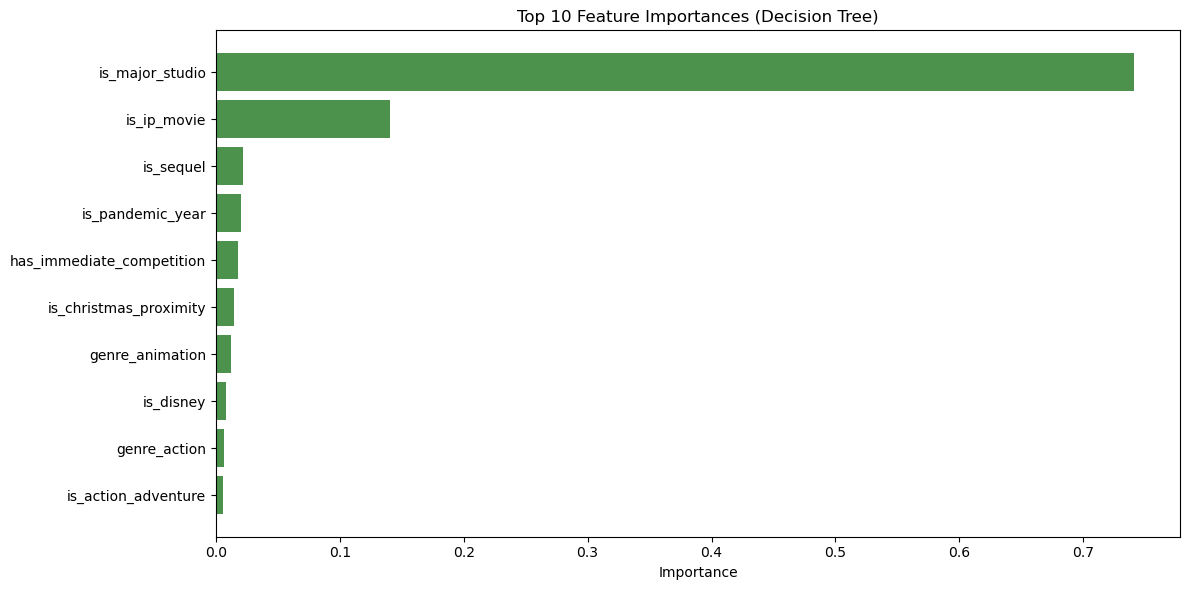


🕒 Alternative Time Features Importance:
   years_since_baseline: 0.000 (rank 61)
   is_pre_streaming_era: 0.000 (rank 62)
   is_streaming_transition: 0.000 (rank 63)
   is_pandemic_year: 0.020 (rank 4)
   is_post_pandemic_era: 0.000 (rank 64)

   Total time features importance: 0.020 (2.0%)


In [11]:
# Analyze feature importance (for tree-based models)
if hasattr(best_model.named_steps, 'rf') or hasattr(best_model.named_steps, 'dt'):
    print("🔍 Feature Importance Analysis")
    print("=" * 50)
    
    # Get the model step
    if hasattr(best_model.named_steps, 'rf'):
        model_step = best_model.named_steps['rf']
    else:
        model_step = best_model.named_steps['dt']
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model_step.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Show top 15 features
    top_features = feature_importance.head(15)
    print("Top 15 Most Important Features:")
    print(top_features.to_string(index=False))
    
    # Visualize top 10 features
    plt.figure(figsize=(12, 6))
    top10_features = feature_importance.head(10)
    plt.barh(top10_features['feature'][::-1], top10_features['importance'][::-1], 
             color='darkgreen', alpha=0.7)
    plt.title(f'Top 10 Feature Importances ({best_model_result["model_name"]})')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Analyze alternative time features importance
    time_features = ['years_since_baseline', 'is_pre_streaming_era', 'is_streaming_transition', 
                    'is_pandemic_year', 'is_post_pandemic_era']
    
    print(f"\n🕒 Alternative Time Features Importance:")
    for feature in time_features:
        if feature in feature_importance['feature'].values:
            importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
            rank = list(feature_importance['feature']).index(feature) + 1
            print(f"   {feature}: {importance:.3f} (rank {rank})")
    
    total_time_importance = feature_importance[
        feature_importance['feature'].isin(time_features)
    ]['importance'].sum()
    print(f"\n   Total time features importance: {total_time_importance:.3f} ({total_time_importance*100:.1f}%)")
    
else:
    print("Feature importance not available for Ridge Regression")
    print("Ridge coefficients provide different interpretability")

## 2026 Predictions Ready!

In [12]:
# Final summary and 2026 readiness
print("🚀 READY FOR 2026 BOX OFFICE PREDICTIONS")
print("=" * 60)

print(f"✅ Best Model Selected: {best_model_result['model_name']}")
print(f"   • Validation RMSE: ${best_model_result['rmse']:,.0f}")
print(f"   • Validation R²: {best_model_result['r2']:.3f}")
print(f"   • Validation MAPE: {best_model_result['mape']:.1f}%")

print(f"\n✅ Safe for 2026 Predictions:")
print(f"   • Uses alternative time features (no data leakage)")
print(f"   • Focused on major studio films")
print(f"   • Weighted training handles pandemic impact")
print(f"   • Temporal validation on 2024 data")

print(f"\n🎯 2026 Feature Values:")
print(f"   • years_since_baseline: {2026 - 2015} (safe extrapolation)")
print(f"   • is_post_pandemic_era: 1 (reasonable assumption)")
print(f"   • All other era flags: 0")

print(f"\n📊 Model Performance Summary:")
for i, result in enumerate(available_results, 1):
    print(f"   {i}. {result['model_name']}: RMSE ${result['rmse']:,.0f}, R² {result['r2']:.3f}")

print(f"\n🎬 Next Steps:")
print(f"   1. Apply best model to 2026 movie data")
print(f"   2. Generate top 10 box office predictions")
print(f"   3. Analyze prediction confidence intervals")
print(f"   4. Create final prediction report")

print(f"\n✨ The model is ready to predict 2026 box office success!")

🚀 READY FOR 2026 BOX OFFICE PREDICTIONS
✅ Best Model Selected: Decision Tree
   • Validation RMSE: $80,903,869
   • Validation R²: 0.404
   • Validation MAPE: 182.4%

✅ Safe for 2026 Predictions:
   • Uses alternative time features (no data leakage)
   • Focused on major studio films
   • Weighted training handles pandemic impact
   • Temporal validation on 2024 data

🎯 2026 Feature Values:
   • years_since_baseline: 11 (safe extrapolation)
   • is_post_pandemic_era: 1 (reasonable assumption)
   • All other era flags: 0

📊 Model Performance Summary:
   1. Ridge Regression: RMSE $81,662,172, R² 0.393
   2. Decision Tree: RMSE $80,903,869, R² 0.404
   3. Random Forest: RMSE $83,841,416, R² 0.360

🎬 Next Steps:
   1. Apply best model to 2026 movie data
   2. Generate top 10 box office predictions
   3. Analyze prediction confidence intervals
   4. Create final prediction report

✨ The model is ready to predict 2026 box office success!
